In [1]:
# pip install torchsummary

In [2]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torch.optim as optim
import torchvision.models as models
from torchvision import models
from torchsummary import summary
from torchvision.models import wide_resnet101_2, Wide_ResNet101_2_Weights
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score, confusion_matrix
import seaborn as sns
from PIL import Image
from sklearn.metrics import classification_report

In [3]:
train_path = '/kaggle/input/casting-512-512/Casting_512_512/train'
test_path = '/kaggle/input/casting-512-512/Casting_512_512/test'

In [4]:
transformations = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [5]:
train_dataset = datasets.ImageFolder(root=train_path, transform=transformations)
test_dataset = datasets.ImageFolder(root=test_path, transform=transformations)

In [6]:
train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)

In [7]:
weights = Wide_ResNet101_2_Weights.IMAGENET1K_V1
model = wide_resnet101_2(weights=weights)

Downloading: "https://download.pytorch.org/models/wide_resnet101_2-32ee1156.pth" to /root/.cache/torch/hub/checkpoints/wide_resnet101_2-32ee1156.pth
100%|██████████| 243M/243M [00:01<00:00, 205MB/s] 


In [8]:
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(train_dataset.classes))

In [9]:
# print(summary(model,(3,224,224)))

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters(), lr=0.001)

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

train_loss_history = []
train_accuracy_history = []

num_epochs = 40

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_accuracy = correct / total * 100
    
    train_loss_history.append(train_loss)
    train_accuracy_history.append(train_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")

Epoch 1/40, Train Loss: 0.8914, Train Accuracy: 57.65%
Epoch 2/40, Train Loss: 0.6446, Train Accuracy: 62.37%
Epoch 3/40, Train Loss: 0.5416, Train Accuracy: 70.93%
Epoch 4/40, Train Loss: 0.5415, Train Accuracy: 69.20%
Epoch 5/40, Train Loss: 0.5353, Train Accuracy: 71.51%
Epoch 6/40, Train Loss: 0.4439, Train Accuracy: 78.73%
Epoch 7/40, Train Loss: 0.3825, Train Accuracy: 82.87%
Epoch 8/40, Train Loss: 0.3304, Train Accuracy: 86.43%
Epoch 9/40, Train Loss: 0.3371, Train Accuracy: 85.95%
Epoch 10/40, Train Loss: 0.2748, Train Accuracy: 88.26%
Epoch 11/40, Train Loss: 0.3297, Train Accuracy: 85.66%
Epoch 12/40, Train Loss: 0.2453, Train Accuracy: 89.70%
Epoch 13/40, Train Loss: 0.2492, Train Accuracy: 90.38%
Epoch 14/40, Train Loss: 0.1781, Train Accuracy: 93.17%
Epoch 15/40, Train Loss: 0.2001, Train Accuracy: 91.63%
Epoch 16/40, Train Loss: 0.1487, Train Accuracy: 95.00%
Epoch 17/40, Train Loss: 0.1073, Train Accuracy: 95.86%
Epoch 18/40, Train Loss: 0.1381, Train Accuracy: 94.71%
E

In [12]:
val_loss_history = []
val_accuracy_history = []

for epoch in range(num_epochs):
    model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for val_inputs, val_labels in test_loader:
            val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
            val_outputs = model(val_inputs)
            val_loss = criterion(val_outputs, val_labels)
            
            val_running_loss += val_loss.item()
            _, val_predicted = torch.max(val_outputs.data, 1)
            val_total += val_labels.size(0)
            val_correct += (val_predicted == val_labels).sum().item()

        # Append the average validation loss for the epoch
        val_loss = val_running_loss / len(test_loader)
        val_loss_history.append(val_loss)

    val_accuracy = 100 * val_correct / val_total
    val_accuracy_history.append(val_accuracy)

print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

Validation Loss: 2.1803, Validation Accuracy: 69.35%


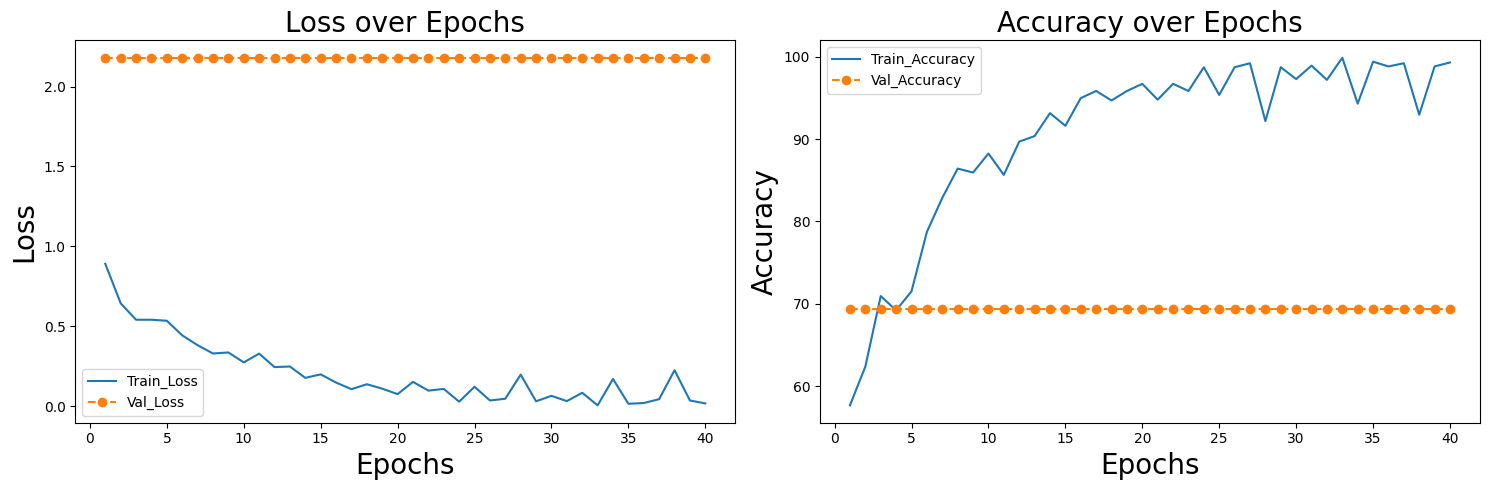

In [13]:
plt.figure(figsize=(15, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_loss_history, label='Train_Loss')
plt.plot(range(1, num_epochs + 1), val_loss_history, label='Val_Loss', linestyle='--', marker='o')
plt.title('Loss over Epochs',fontsize=20)
plt.xlabel('Epochs',fontsize=20)
plt.ylabel('Loss',fontsize=20)
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracy_history, label='Train_Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracy_history, label='Val_Accuracy', linestyle='--', marker='o')
plt.title('Accuracy over Epochs',fontsize=20)
plt.xlabel('Epochs',fontsize=20)
plt.ylabel('Accuracy',fontsize=20)
plt.legend()

plt.tight_layout()
plt.savefig('Loss and Accuracy.png', dpi=300)
plt.show()

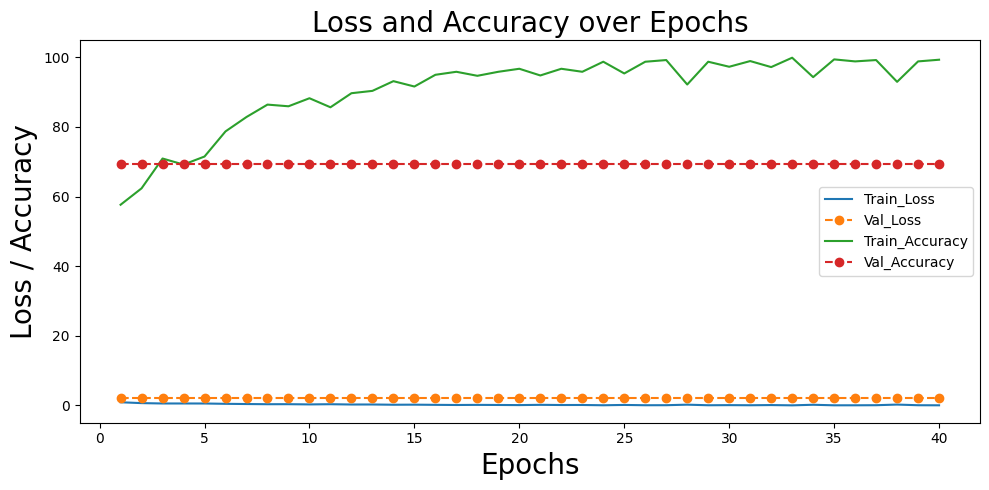

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))

# Loss plot
plt.plot(range(1, num_epochs + 1), train_loss_history, label='Train_Loss')
plt.plot(range(1, num_epochs + 1), val_loss_history, label='Val_Loss', linestyle='--', marker='o')

# Accuracy plot
plt.plot(range(1, num_epochs + 1), [acc for acc in train_accuracy_history], label='Train_Accuracy')
plt.plot(range(1, num_epochs + 1), [acc for acc in val_accuracy_history], label='Val_Accuracy', linestyle='--', marker='o')

plt.title('Loss and Accuracy over Epochs',fontsize=20)
plt.xlabel('Epochs',fontsize=20)
plt.ylabel('Loss / Accuracy',fontsize=20)
plt.legend()

plt.tight_layout()
plt.savefig('Loss and AccuracySingle.png', dpi=300)
plt.show()

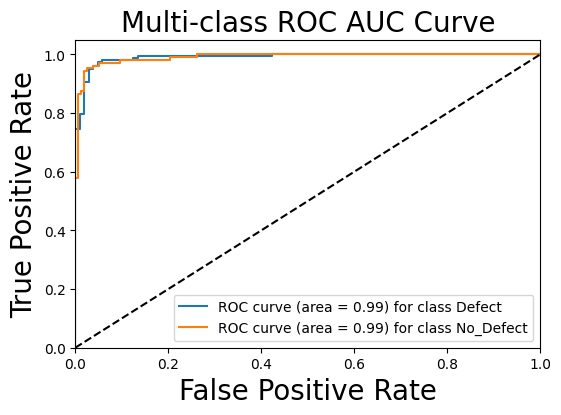

In [15]:
def plot_roc_curve(fpr, tpr, roc_auc, classes):
    plt.figure(figsize=(6, 4))
    for i in range(len(classes)):
        plt.plot(fpr[i], tpr[i], label=f'ROC curve (area = {roc_auc[i]:.2f}) for class {classes[i]}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate',fontsize=20)
    plt.ylabel('True Positive Rate',fontsize=20)
    plt.title('Multi-class ROC AUC Curve',fontsize=20)
    plt.legend(loc="lower right")
    plt.savefig('ROC_AUC.png', dpi=300)
    plt.show()

model.eval()
y_pred = []
y_true = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)

        y_pred.extend(outputs.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

y_pred = np.array(y_pred)
y_true = np.array(y_true)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(train_dataset.classes)):
    fpr[i], tpr[i], _ = roc_curve(y_true == i, y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plot_roc_curve(fpr, tpr, roc_auc, train_dataset.classes)

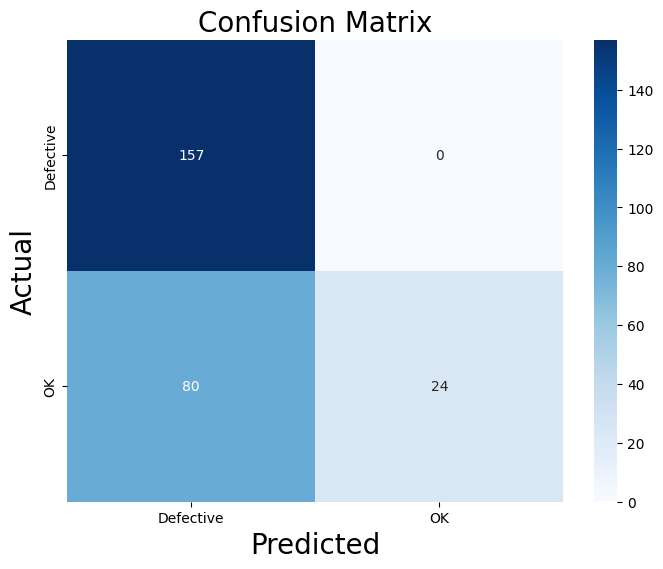

In [16]:
class_predictions = np.argmax(y_pred, axis=1)
cm = confusion_matrix(y_true, class_predictions)
labels = ['Defective', 'OK']

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix',fontsize=20)
plt.ylabel('Actual',fontsize=20)
plt.xlabel('Predicted',fontsize=20)
plt.savefig('ConfusionMatrix.png', dpi=300)
plt.show()

In [17]:
print(classification_report(y_true, class_predictions, target_names=train_dataset.classes))

              precision    recall  f1-score   support

      Defect       0.66      1.00      0.80       157
   No_Defect       1.00      0.23      0.38       104

    accuracy                           0.69       261
   macro avg       0.83      0.62      0.59       261
weighted avg       0.80      0.69      0.63       261



In [19]:
torch.save(model.state_dict(), 'Wide_ResNet.pth')